# **Text Classifier with the News Headlines Dataset**

This notebook demonstrates the implementation of a text classification model using a Transformer network for sarcasm detection, a more challenging task compared to traditional sentiment analysis. Its purpose is to determine whether news headlines are sarcastic or not, using the [News Headlines Dataset for Sarcasm Detection](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/home). For this task, the pre-trained [RoBERTa (Robustly Optimized BERT Pretraining Approach)](https://huggingface.co/docs/transformers/en/model_doc/roberta) model from [Hugging Face 🤗](https://huggingface.co/) is fine-tuned to improve its performance in sarcasm detection. Hugging Face is a platform focused on developing tools and AI models for natural language processing (NLP). It is known for its open-source library called Transformers, which provides a simple interface for working with advanced and pre-trained NLP models such as BERT, T5, GPT, and others.

**Key Points:**
- **Model Architecture:** The RoBERTa Large model from Hugging Face is used, which is based on [BERT](https://huggingface.co/docs/transformers/en/model_doc/bert), but achieves better results on GLUE, RACE, and SQuAD, datasets used to evaluate text comprehension and reasoning models. It is loaded using the generic class [TFAutoModel](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodel), which allows instantiating a pre-trained model based on TensorFlow with just its name. Then, it is fine-tuned by adding a dropout layer and a dense classification layer with ``sigmoid`` activation, where 0 indicates a non-sarcastic headline and 1 indicates a sarcastic headline.

- **Tokenization:** RoBERTa uses ``input_ids``, which are the indices of the tokenized input sequence in the vocabulary, and ``attention_mask``, a mask to avoid paying attention to padding token indices. Hugging Face has already implemented a tokenizer for each of its models that returns everything needed for the respective model's inputs, so for this case, the generic tokenizer [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) will be used, which allows instantiating the model's tokenizer with just its name.

- **Using a TPU:** Due to the massive size of the RoBERTa model, specifically `roberta-large`, which has over 300 million parameters, the use of a TPU in Google Colab is required to significantly accelerate training. Although only the parameters of the classification layer are adjusted during fine-tuning, loading and processing pre-trained embeddings, along with intensive backpropagation calculations, require considerable computational resources. The TPU facilitates efficient handling of these tasks compared to GPUs or CPUs, optimizing performance and training time.

- **Comparison with the [Bidirectional LSTM Network Model](https://github.com/JersonGB22/TextClassification-TensorFlow/blob/main/models_lstm/SentimentAnalysis_LSTM_Sarcasm.ipynb):** In this notebook, the results obtained with the Transformer network using the RoBERTa model will be compared with the results obtained from the model with a bidirectional LSTM network.

### **Imports**

In [ ]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from IPython.core.display import HTML
from google.colab import drive

In [ ]:
# TPU setup
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except ValueError:
  print("TPU not found")

TPU initialized:
All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


### **Parameters**

In [ ]:
epochs = 3
batch_size = 32
buffer_size = 1024
max_length = 64 #The headlines are short texts
AUTOTUNE = tf.data.AUTOTUNE
model_name = "roberta-large"

### **Load and Preprocess the Dataset**

In [ ]:
data_url = "https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json"
data_path = "/content/sarcasm.json"

# Download dataset
!wget -q $data_url  -O $data_path

In [ ]:
df = pd.read_json(data_path)
df

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


In [ ]:
# There are no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [ ]:
# The dataset is roughly balanced
(df.is_sarcastic.value_counts()/df.shape[0]) * 100

is_sarcastic
0    56.104684
1    43.895316
Name: count, dtype: float64

In [ ]:
# Import the AutoTokenizer
# 'use_fast=True': improves the tokenizer's performance when processing large volumes of text

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer

RobertaTokenizerFast(name_or_path='roberta-large', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [ ]:
# Example of tokenization

sample_text = df.headline[3]
print(sample_text)
encoding = tokenizer(
    sample_text,
    padding="max_length",
    truncation=True,
    max_length=25,
    return_tensors="tf" #Returns the results in TensorFlow tensor format
)

print(encoding["input_ids"].numpy()[0])
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"][0]))
print(tokenizer.decode(encoding["input_ids"][0]), "\n")

print(encoding["attention_mask"].numpy()[0])

boehner just wants wife to listen, not come up with alternative debt-reduction ideas
[    0  3983 14897  1396    95  1072  1141     7  4161     6    45   283
    62    19  3626  1126    12  2050 27345  2956     2     1     1     1
     1]
['<s>', 'bo', 'eh', 'ner', 'Ġjust', 'Ġwants', 'Ġwife', 'Ġto', 'Ġlisten', ',', 'Ġnot', 'Ġcome', 'Ġup', 'Ġwith', 'Ġalternative', 'Ġdebt', '-', 'red', 'uction', 'Ġideas', '</s>', '<pad>', '<pad>', '<pad>', '<pad>']
<s>boehner just wants wife to listen, not come up with alternative debt-reduction ideas</s><pad><pad><pad><pad> 

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]


Unlike BERT, RoBERTa uses a byte-level BPE (Byte Pair Encoding) as a tokenizer, similar to GPT-2.

In [ ]:
# Function to convert texts to lowercase and then tokenize them

def preprocessing(texts):
  if type(texts) == list:
    texts = list(map(str.lower, texts))
  else:
    texts = texts.lower()

  encoding = tokenizer(
      texts,
      padding="max_length",
      truncation=True,
      max_length=max_length,
      return_tensors="tf"
  )

  return encoding["input_ids"], encoding["attention_mask"]

In [ ]:
# Splitting the dataframe into training and testing sets

df_train, df_test = train_test_split(df, test_size=0.15, random_state=123, stratify=df["is_sarcastic"])

train_dataset = tf.data.Dataset.from_tensor_slices(
    (preprocessing(df_train.headline.to_list()), df_train["is_sarcastic"].values)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (preprocessing(df_test.headline.to_list()), df_test["is_sarcastic"].values)
)

train_dataset = train_dataset.shuffle(buffer_size, seed=123).batch(batch_size).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

In [ ]:
# View a processed batch

for (ids, masks), labels in train_dataset.take(1):
  print(ids, "\n")
  print(masks, "\n")
  print(labels)

tf.Tensor(
[[    0 26302  4189 ...     1     1     1]
 [    0 31818    95 ...     1     1     1]
 [    0   306 20125 ...     1     1     1]
 ...
 [    0  9178     7 ...     1     1     1]
 [    0  8458   225 ...     1     1     1]
 [    0  1069   298 ...     1     1     1]], shape=(32, 64), dtype=int32) 

tf.Tensor(
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(32, 64), dtype=int32) 

tf.Tensor([0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0], shape=(32,), dtype=int64)


In [ ]:
# Thanks to the 'stratify' argument, the distribution is preserved

print(len(df_train), len(df_test), "\n")
print((df_train.is_sarcastic.value_counts()/df_train.shape[0]) * 100, "\n")
print((df_test.is_sarcastic.value_counts()/df_test.shape[0]) * 100)

22702 4007 

is_sarcastic
0    56.105189
1    43.894811
Name: count, dtype: float64 

is_sarcastic
0    56.101822
1    43.898178
Name: count, dtype: float64


### **Build the Model**

In [ ]:
def create_model():
  # Import the AutoModel
  model_base = TFAutoModel.from_pretrained(model_name)

  input_ids = tf.keras.Input((max_length, ), dtype=tf.int32)
  attention_mask = tf.keras.Input((max_length, ), dtype=tf.int32)

  x = model_base(input_ids=input_ids, attention_mask=attention_mask).pooler_output
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

  model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=x)

  return model

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

# Creation and compilation of the model within the distribution strategy
with strategy.scope():
  model = create_model()

  model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=2e-5, weight_decay=0.01),
                loss="binary_crossentropy",
                metrics=["accuracy"],
                steps_per_execution=100)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

The message indicates that it is recommended to train the model on a downstream task before using it for predictions and inferences. This is correct, as the model has not been fine-tuned yet.

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  355359744  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 64,                                            

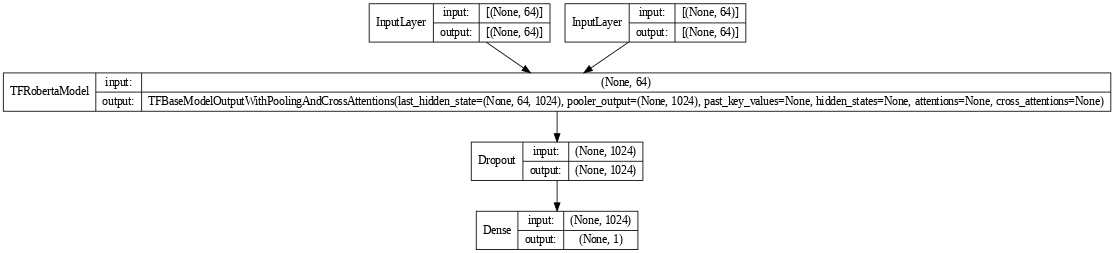

In [ ]:
# Visualizing the architecture of the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, dpi=60)

### **Train the Model**

In [ ]:
tf.random.set_seed(123)
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/3
710/710 [==============================] - 267s 375ms/step - loss: 0.2789 - accuracy: 0.8762 - val_loss: 0.1554 - val_accuracy: 0.9386
Epoch 2/3
710/710 [==============================] - 60s 84ms/step - loss: 0.1288 - accuracy: 0.9514 - val_loss: 0.1711 - val_accuracy: 0.9354
Epoch 3/3
710/710 [==============================] - 60s 84ms/step - loss: 0.0751 - accuracy: 0.9734 - val_loss: 0.1749 - val_accuracy: 0.9478


**Save model**

Due to the large size of the model, only its weights are saved.

In [ ]:
drive.mount("/content/drive/")

trained_model_path = "/content/drive/MyDrive/models/SentimentAnalysis_RoBERTa_Sarcasm.h5"
model.save_weights(trained_model_path)

Mounted at /content/drive/


### **Dataset Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.015240246430039406, 0.9950224757194519]
[0.17489857971668243, 0.9478412866592407]


The training set achieves an accuracy of 99.5% in just 3 epochs, while the test set accuracy is 94.8%. This demonstrates that the Transformer model is significantly superior to the bidirectional LSTM model, which achieved only an 86.3% accuracy on the test set. There is a noticeable reduction in overfitting; however, the model still exhibits some overfitting. This could be mitigated by increasing the size of the training set, since we are already using a robust model for NLP tasks with the selection of appropriate hyperparameters.

**Confusion Matrix**

In [ ]:
labels_test = test_dataset.unbatch().map(lambda text, label: label)
labels_test = np.array(list(labels_test.as_numpy_iterator()))

labels_test_pred = model.predict(test_dataset, verbose=0).squeeze()
labels_test_pred = (labels_test_pred>=0.5).astype(np.int32)

In [ ]:
# Consolidating the accuracy of the testing set
np.mean(labels_test == labels_test_pred)

0.9478412777639131

Total non-sarcastic:  2248 ; Total sarcastic:  1759


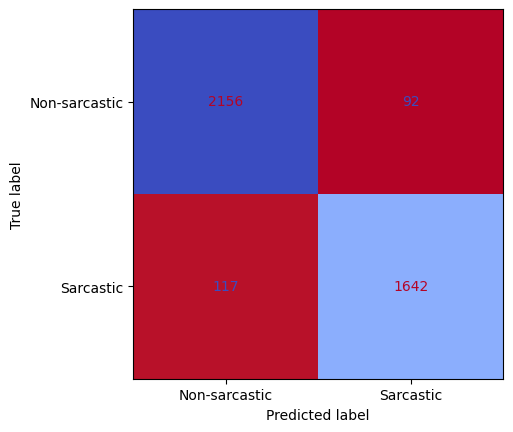

In [ ]:
cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Non-sarcastic", "Sarcastic"])
cmd.plot(colorbar=False, cmap="coolwarm_r");
print("Total non-sarcastic: ", np.bincount(labels_test)[0], "; Total sarcastic: ", np.bincount(labels_test)[1])

In [ ]:
(92/2248)*100, (117/1759)*100

(4.092526690391459, 6.651506537805571)

It is observed that the model encounters slightly greater difficulty in correctly classifying sarcastic news headlines, as reflected in a higher percentage of false negatives (6.7%) compared to false positives (4.1%). However, in comparison with the LSTM network, it has improved significantly. This is because the model is quite capable of detecting the complex relationships required for sarcasm detection, akin to how humans would do it, due to the pretraining of RoBERTa.

### **Predictions with the trained model**

**``Example of how to save and load the complete model``**

```
trained_model_path = "/content/drive/MyDrive/models/SentimentAnalysis_RoBERTa_Sarcasm.keras"
model.save(trained_model_path)

model_base = TFAutoModel.from_pretrained(model_name)
model = tf.keras.models.load_model(trained_model_path,
                                  custom_objects={"TFRobertaModel": model_base})

model.summary()
```

In [ ]:
# Load the weights of the trained model
tf.keras.backend.clear_session()

model = create_model()
model.load_weights(trained_model_path)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   3553597   ['input_1[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   44         'input_2[0][0]']             
                             hidden_state=(None, 64, 10                                           
                             24),                                                             

In [ ]:
def predict_sarcasm(texts, labels, random=True):
  label_names = ["Non-sarcastic Headline", "Sarcastic Headline"]
  label_colors = ["blue", "orange"]

  indice = np.random.choice(len(texts)) if random else 0
  text = texts[indice]
  input_ids, attention_mask = preprocessing(text)

  label_pred = model.predict([input_ids, attention_mask], verbose=0).squeeze()
  label_pred = (label_pred>=0.5).astype(np.int32)

  html_content = f"""
    <b>News Headline:</b><br><br>
    {text}<br><br>
    <b>True Label: <span style="color: {label_colors[labels[indice]]}">{label_names[labels[indice]]}</span></b><br><br>
    <b>Predicted Label: <span style="color: {label_colors[label_pred]}">{label_names[label_pred]}</span></b>
    """
  display(HTML(html_content))

**Test Dataset**

In [ ]:
texts, labels = df_test.headline.to_list(), df_test.is_sarcastic.to_list()

In [ ]:
predict_sarcasm(texts, labels, random=False)

In [ ]:
predict_sarcasm(texts, labels)

In [ ]:
predict_sarcasm(texts, labels)

In [ ]:
predict_sarcasm(texts, labels)

In [ ]:
predict_sarcasm(texts, labels)

In [ ]:
predict_sarcasm(texts, labels)

In [ ]:
# More complex news headline
predict_sarcasm([texts[80]], [labels[80]])

Correct prediction! The news headline is quite complex even for a human, as it requires a deep understanding of the context. At first glance, it may not seem sarcastic, but it is. However, the Transformer model predicted it correctly, thanks to its multiple layers of attention that capture complex relationships within sentences.

**Other News Headlines**

In [ ]:
text = ["New Study Reveals Surprising Benefits of Meditation for Stress Reduction"]
label = [0]
predict_sarcasm(text, label)

In [ ]:
text = ["Scientists Discover Groundbreaking Method to Turn Water into Wine"]
label = [1]

predict_sarcasm(text, label)

In [ ]:
text = ["Government announces new tax relief measures for small businesses, aims to boost economic recovery."]
label = [0]
predict_sarcasm(text, label)

In [ ]:
text = ["New study finds that chocolate makes you gain weight, who knew?"]
label = [1]
predict_sarcasm(text, label)